In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
# from statsmodels import api
from scipy import stats
from scipy.optimize import minimize
from lifetimes.fitters.pareto_nbd_fitter import ParetoNBDFitter
from lifetimes.fitters.gamma_gamma_fitter import GammaGammaFitter
from sklearn.ensemble import RandomForestRegressor
from scipy.special import gamma
from sklearn.metrics import mean_squared_error, r2_score
import math
from math import sqrt

from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data

In [2]:
def get_model(data, penalizer_val, time):
    pareto_result = data.copy()

    pareto_model = ParetoNBDFitter(penalizer_coef=penalizer_val)
    pareto_model.fit(pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])

    # calculating the predicted_purchases

    t = time

    pareto_result["predicted_purchases"] = pareto_model.conditional_expected_number_of_purchases_up_to_time(t,
                                                                                                            pareto_result[
                                                                                                                "frequency"],
                                                                                                            pareto_result[
                                                                                                                "recency"],
                                                                                                            pareto_result[
                                                                                                                "T"])

    pareto_result["Actual_Purchases"] = pareto_result["frequency"] / pareto_result["recency"] * time

    # filling the null values
    pareto_result["Actual_Purchases"].fillna(0, inplace=True)

    # calculating the error
    pareto_result["Prediction_Error"] = pareto_result["Actual_Purchases"] - pareto_result["predicted_purchases"]

    # calcuating the purchase prediction error
    pareto_mse_purchase = mean_squared_error(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"])
    pareto_r2_purchase = r2_score(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"])
    pareto_rmse_purchase = sqrt(
        mean_squared_error(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"]))
    pareto_avg_error_purchase = pareto_result["Prediction_Error"].mean()

    # printing the purchase prediction error
    print("Predicted Purchase Mean Squared Error: %s" % (pareto_mse_purchase))
    print("Predicted Purchase R2 Score: %s" % (pareto_r2_purchase))
    print("Predicted Purchase Root Mean Squared Error: %s" % (pareto_rmse_purchase))
    print("Predicted Purchase Average Purchases Error: %s" % (pareto_avg_error_purchase))

    # plotting the prediction v/s actual purchase plot
    plt.figure(figsize=(6, 4))
    plt.errorbar(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"],
                 yerr=pareto_result["Prediction_Error"], fmt='o', color='darkseagreen',
                 ecolor='grey', elinewidth=1.5, capsize=0, alpha=0.2);
    plt.title("Prediction v/s Actual")

In [3]:
customer_rfm = pd.read_csv('C:\\Users\\il.pugin\\Downloads\\customer_rfm\\customer_rfm.csv')
# print(customer_rfm.head(10))
# print(customer_rfm.columns)

In [10]:
rfm_fixed = customer_rfm.dropna()

In [7]:
# fit a model
pareto_model = ParetoNBDFitter(penalizer_coef=0.0)
pareto_model.fit(customer_rfm['frequency'], customer_rfm['recency'], customer_rfm['t'])

C:\Python\Lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\il.pugin\PycharmProjects\diploma\venv\Lib\site-packages\lifetimes\fitters\pareto_nbd_fitter.py:216: RuntimeWarning: invalid value encountered in logaddexp
  A_2 = logaddexp(-(r + x) * log(alpha + T) - s * log(beta + T), log(s) + log_A_0 - log(r_s_x))
C:\Users\il.pugin\PycharmProjects\diploma\venv\Lib\site-packages\scipy\special\_logsumexp.py:109: RuntimeWarning: overflow encountered in exp
  tmp = b * np.exp(a - a_max)


<lifetimes.ParetoNBDFitter: fitted with 433775 subjects, alpha: 23.20, beta: 396.53, r: 1.95, s: 0.53>

In [8]:
pareto_result = customer_rfm.copy()

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

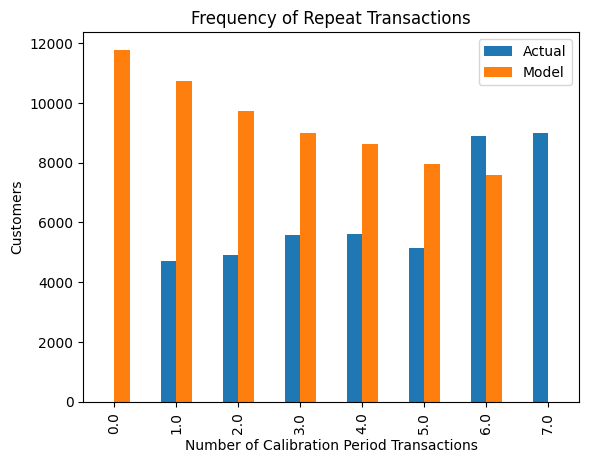

In [9]:
plot_period_transactions(pareto_model)

<Axes: >

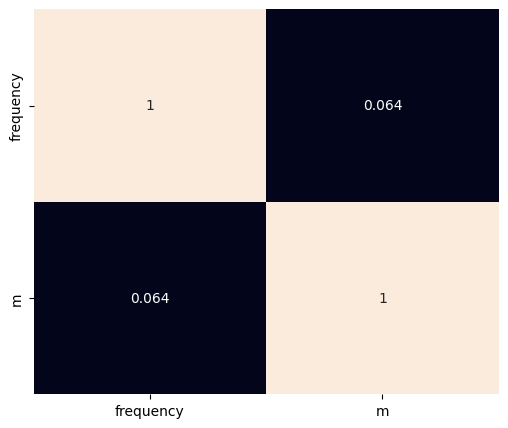

In [13]:
plt.figure(figsize=(6,5))
sns.heatmap(customer_rfm[["frequency", "m"]].corr(), annot = True, cbar = False)

In [15]:
ggf_model =  GammaGammaFitter(penalizer_coef=0.1)
ggf_model.fit(customer_rfm["frequency"], customer_rfm["m"])

<lifetimes.GammaGammaFitter: fitted with 433775 subjects, p: 0.96, q: 0.19, v: 0.94>

In [17]:
ggf_model.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,0.956136,0.002481,0.951273,0.960999
q,0.185318,0.000303,0.184725,0.185912
v,0.943679,0.002501,0.938776,0.948581


In [19]:
pareto_model.summary

AttributeError: 'ParetoNBDFitter' object has no attribute 'standard_errors_'

In [26]:
cltv_predict = ggf_model.customer_lifetime_value(pareto_model, customer_rfm_test['frequency']*0, customer_rfm_test['recency']*0, customer_rfm_test['t']*0, customer_rfm_test['m'], time=29, discount_rate=0.3/12, freq='D')

C:\Users\il.pugin\PycharmProjects\diploma\venv\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [27]:
cltv_act = ggf_model.customer_lifetime_value(pareto_model, customer_rfm_test['frequency'], customer_rfm_test['recency'], customer_rfm_test['t'], customer_rfm_test['m'], time=29, discount_rate=0.3/12, freq='D')

C:\Users\il.pugin\PycharmProjects\diploma\venv\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [28]:
import numpy as np
from sklearn import metrics

gt = cltv_act
pred = cltv_predict

def results_print(gt, pred):
    print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(gt, pred))
    print('Mean Squared Error (MSE):', metrics.mean_squared_error(gt, pred))
    print('R squared (R2):', metrics.r2_score(gt, pred))
    print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(gt, pred)))
    mape = np.mean(np.abs((gt - pred) / np.abs(gt)))
    print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
    print('Accuracy:', round(100*(1 - mape), 2))

results_print(gt, pred)

Mean Absolute Error (MAE): 19296.638143576736
Mean Squared Error (MSE): 4341794485.388352
R squared (R2): -0.09380688051920516
Root Mean Squared Error (RMSE): 65892.2945828141
Mean Absolute Percentage Error (MAPE): 1.4550677160568415e+197
Accuracy: -1.4550677160568415e+197


In [25]:
customer_rfm_test = pd.read_csv("C:\\Users\\il.pugin\\Downloads\\customer_rfm_test\\customer_rfm_test.csv")

In [29]:
# fit a model
pareto_model_new = ParetoNBDFitter(penalizer_coef=0.0)
pareto_model_new.fit(customer_rfm_test['frequency'], customer_rfm_test['recency'], customer_rfm_test['t'])

C:\Python\Lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\il.pugin\PycharmProjects\diploma\venv\Lib\site-packages\lifetimes\fitters\pareto_nbd_fitter.py:216: RuntimeWarning: invalid value encountered in logaddexp
  A_2 = logaddexp(-(r + x) * log(alpha + T) - s * log(beta + T), log(s) + log_A_0 - log(r_s_x))
C:\Users\il.pugin\PycharmProjects\diploma\venv\Lib\site-packages\scipy\special\_logsumexp.py:109: RuntimeWarning: overflow encountered in exp
  tmp = b * np.exp(a - a_max)


<lifetimes.ParetoNBDFitter: fitted with 151414 subjects, alpha: 18.08, beta: 394.80, r: 1.52, s: 0.52>

In [30]:
ggf_model_new =  GammaGammaFitter(penalizer_coef=0.1)
ggf_model_new.fit(customer_rfm_test["frequency"], customer_rfm_test["m"])

<lifetimes.GammaGammaFitter: fitted with 151414 subjects, p: 0.95, q: 0.18, v: 0.94>

In [31]:
cltv_predict = ggf_model_new.customer_lifetime_value(pareto_model_new, customer_rfm_test['frequency']*0, customer_rfm_test['recency']*0, customer_rfm_test['t']*0, customer_rfm_test['m'], time=29, discount_rate=0.3/12, freq='D')

C:\Users\il.pugin\PycharmProjects\diploma\venv\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [32]:
cltv_act = ggf_model_new.customer_lifetime_value(pareto_model_new, customer_rfm_test['frequency'], customer_rfm_test['recency'], customer_rfm_test['t'], customer_rfm_test['m'], time=29, discount_rate=0.3/12, freq='D')

C:\Users\il.pugin\PycharmProjects\diploma\venv\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [33]:
import numpy as np
from sklearn import metrics

gt = cltv_act
pred = cltv_predict

def results_print(gt, pred):
    print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(gt, pred))
    print('Mean Squared Error (MSE):', metrics.mean_squared_error(gt, pred))
    print('R squared (R2):', metrics.r2_score(gt, pred))
    print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(gt, pred)))
    mape = np.mean(np.abs((gt - pred) / np.abs(gt)))
    print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
    print('Accuracy:', round(100*(1 - mape), 2))

results_print(gt, pred)

Mean Absolute Error (MAE): 19392.297354359463
Mean Squared Error (MSE): 4392036838.511236
R squared (R2): -0.09364130418590055
Root Mean Squared Error (RMSE): 66272.44403604892
Mean Absolute Percentage Error (MAPE): 1.1885001344349786e+199
Accuracy: -1.1885001344349786e+199
